In [1]:
import pandas as pd
import env
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')



In [62]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


def get_zillow_data():
    filename = 'zillow.csv'

    query = '''
            select prop.parcelid
        , pred.logerror
        , bathroomcnt
        , bedroomcnt
        , calculatedfinishedsquarefeet
        , fips
        , latitude
        , longitude
        , lotsizesquarefeet
        , regionidcity
        , regionidcounty
        , regionidzip
        , yearbuilt
        , structuretaxvaluedollarcnt
        , taxvaluedollarcnt
        , landtaxvaluedollarcnt
        , taxamount
    from properties_2017 prop
    inner join predictions_2017 pred on prop.parcelid = pred.parcelid
    where propertylandusetypeid = 261;  
        '''
    df = pd.read_sql(query, get_connection('zillow')) 
    df.to_csv(filename)
    return df


In [63]:
df=get_zillow_data()

In [7]:
df.head().T

,0,1,2,3,4
parcelid,1.429752e+07,1.705289e+07,1.418624e+07,1.217790e+07,1.209508e+07
logerror,2.559490e-02,5.561909e-02,5.382853e-03,-1.034097e-01,-1.010962e-03
bathroomcnt,3.500000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
bedroomcnt,4.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00
calculatedfinishedsquarefeet,3.100000e+03,1.465000e+03,1.243000e+03,2.376000e+03,2.962000e+03
fips,6.059000e+03,6.111000e+03,6.059000e+03,6.037000e+03,6.037000e+03
latitude,3.363493e+07,3.444927e+07,3.388617e+07,3.424518e+07,3.414520e+07
longitude,-1.178692e+08,-1.192815e+08,-1.178232e+08,-1.182407e+08,-1.181798e+08
lotsizesquarefeet,4.506000e+03,1.264700e+04,8.432000e+03,1.303800e+04,6.300000e+04
regionidcity,5.357100e+04,1.309100e+04,2.141200e+04,3.965510e+05,4.701900e+04


In [8]:
df.shape


(52442, 17)

In [9]:
df.isna().sum().sum()


1720

In [11]:
df.dropna(inplace=True)


In [12]:
df.isna().sum().sum()


0

In [13]:
print('We dropped {} rows'.format(52442-df.shape[0]))


We dropped 1529 rows


In [14]:
def get_counties():
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['regionidcounty'])
    return df_dummies

In [15]:
df = get_counties()
df.head().T


,0,1,2,3,4
parcelid,1.429752e+07,1.705289e+07,1.418624e+07,1.217790e+07,1.209508e+07
logerror,2.559490e-02,5.561909e-02,5.382853e-03,-1.034097e-01,-1.010962e-03
bathroomcnt,3.500000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
bedroomcnt,4.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00
calculatedfinishedsquarefeet,3.100000e+03,1.465000e+03,1.243000e+03,2.376000e+03,2.962000e+03
fips,6.059000e+03,6.111000e+03,6.059000e+03,6.037000e+03,6.037000e+03
latitude,3.363493e+07,3.444927e+07,3.388617e+07,3.424518e+07,3.414520e+07
longitude,-1.178692e+08,-1.192815e+08,-1.178232e+08,-1.182407e+08,-1.181798e+08
lotsizesquarefeet,4.506000e+03,1.264700e+04,8.432000e+03,1.303800e+04,6.300000e+04
regionidcity,5.357100e+04,1.309100e+04,2.141200e+04,3.965510e+05,4.701900e+04


In [16]:
def create_features(df):
    df['age'] = 2017 - df.yearbuilt
    df['age_bin'] = pd.cut(df.age, 
                           bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140],
                           labels = [0, .066, .133, .20, .266, .333, .40, .466, .533, 
                                     .60, .666, .733, .8, .866, .933])

    # create taxrate variable
    df['taxrate'] = df.taxamount/df.taxvaluedollarcnt*100

    # create acres variable
    df['acres'] = df.lotsizesquarefeet/43560

    # bin acres
    df['acres_bin'] = pd.cut(df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], 
                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

    # square feet bin
    df['sqft_bin'] = pd.cut(df.calculatedfinishedsquarefeet, 
                            bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000],
                            labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                       )

    # dollar per square foot-structure
    df['structure_dollar_per_sqft'] = df.structuretaxvaluedollarcnt/df.calculatedfinishedsquarefeet


    df['structure_dollar_sqft_bin'] = pd.cut(df.structure_dollar_per_sqft, 
                                             bins = [0, 25, 50, 75, 100, 150, 200, 300, 500, 1000, 1500],
                                             labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                            )


    # dollar per square foot-land
    df['land_dollar_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet

    df['lot_dollar_sqft_bin'] = pd.cut(df.land_dollar_per_sqft, bins = [0, 1, 5, 20, 50, 100, 250, 500, 1000, 1500, 2000],
                                       labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9]
                                      )


    # update datatypes of binned values to be float
    df = df.astype({'sqft_bin': 'float64', 'acres_bin': 'float64', 'age_bin': 'float64',
                    'structure_dollar_sqft_bin': 'float64', 'lot_dollar_sqft_bin': 'float64'})


    # ratio of bathrooms to bedrooms
    df['bath_bed_ratio'] = df.bathroomcnt/df.bedroomcnt

    # 12447 is the ID for city of LA. 
    # I confirmed through sampling and plotting, as well as looking up a few addresses.
    df['cola'] = df['regionidcity'].apply(lambda x: 1 if x == 12447.0 else 0)

    return df


In [17]:
df = create_features(df)
df.head().T


,0,1,2,3,4
parcelid,1.429752e+07,1.705289e+07,1.418624e+07,1.217790e+07,1.209508e+07
logerror,2.559490e-02,5.561909e-02,5.382853e-03,-1.034097e-01,-1.010962e-03
bathroomcnt,3.500000e+00,1.000000e+00,2.000000e+00,3.000000e+00,3.000000e+00
bedroomcnt,4.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,4.000000e+00
calculatedfinishedsquarefeet,3.100000e+03,1.465000e+03,1.243000e+03,2.376000e+03,2.962000e+03
fips,6.059000e+03,6.111000e+03,6.059000e+03,6.037000e+03,6.037000e+03
latitude,3.363493e+07,3.444927e+07,3.388617e+07,3.424518e+07,3.414520e+07
longitude,-1.178692e+08,-1.192815e+08,-1.178232e+08,-1.182407e+08,-1.181798e+08
lotsizesquarefeet,4.506000e+03,1.264700e+04,8.432000e+03,1.303800e+04,6.300000e+04
regionidcity,5.357100e+04,1.309100e+04,2.141200e+04,3.965510e+05,4.701900e+04


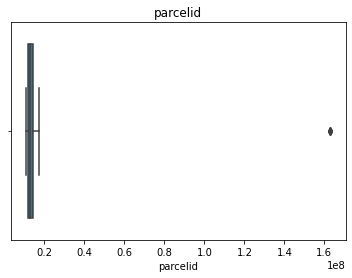

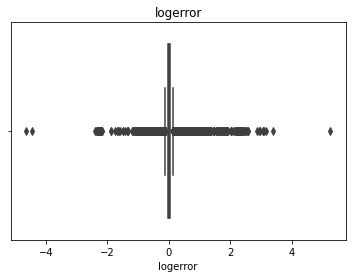

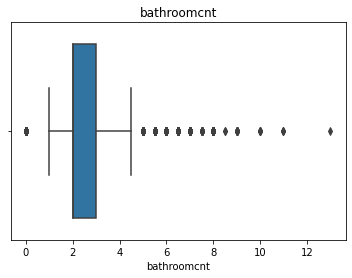

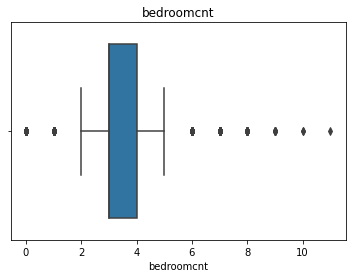

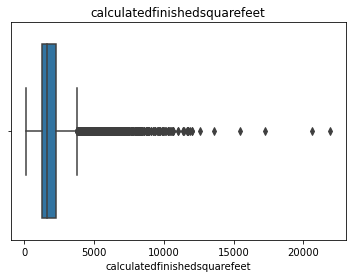

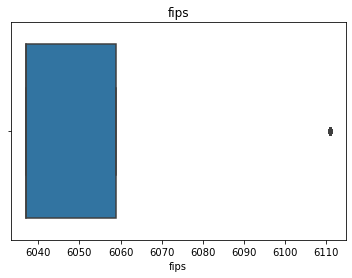

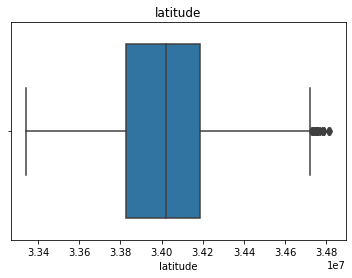

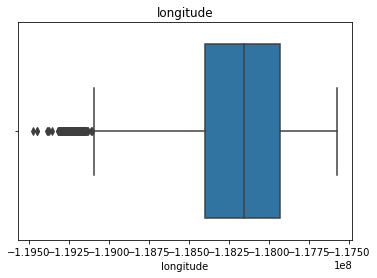

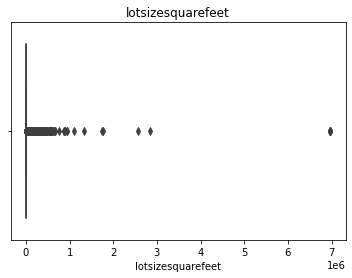

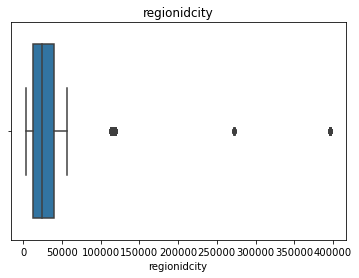

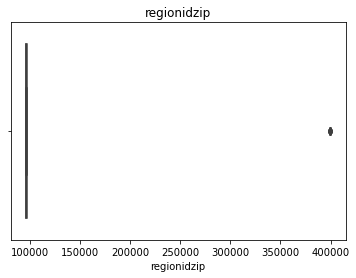

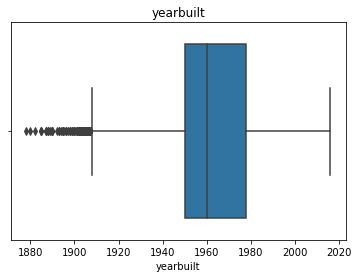

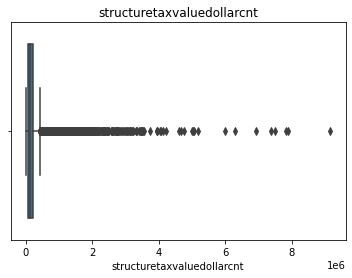

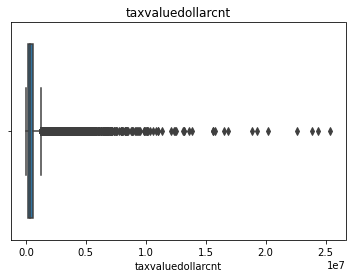

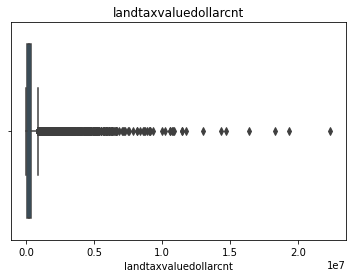

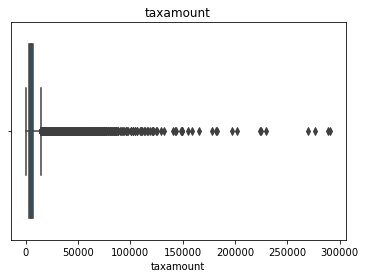

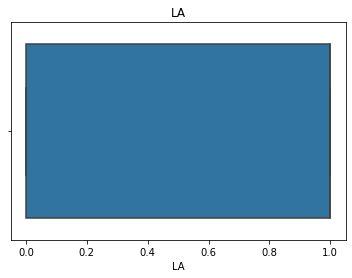

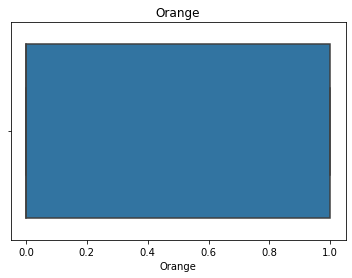

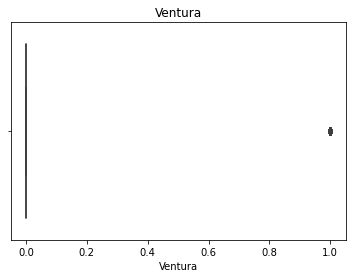

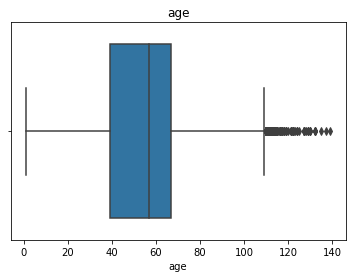

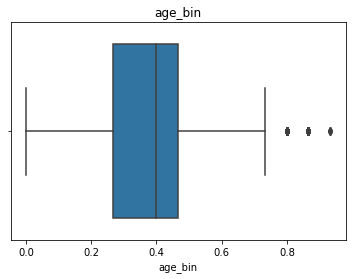

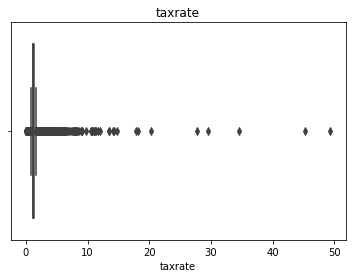

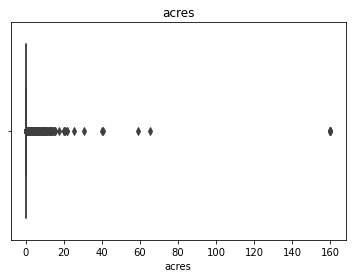

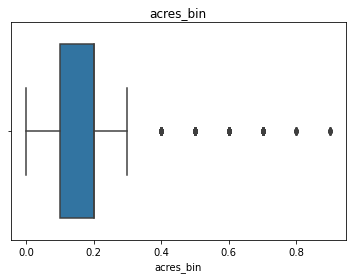

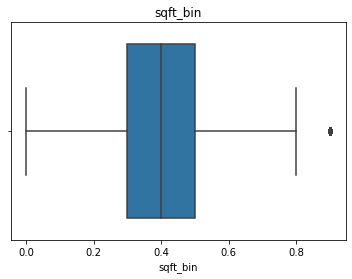

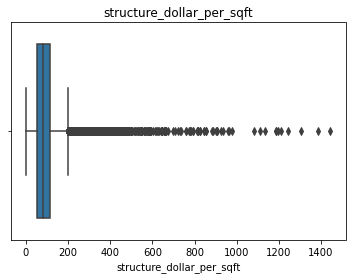

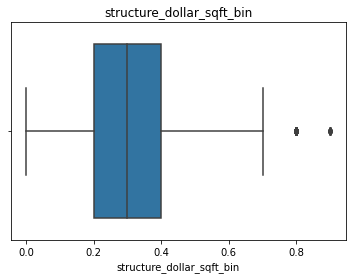

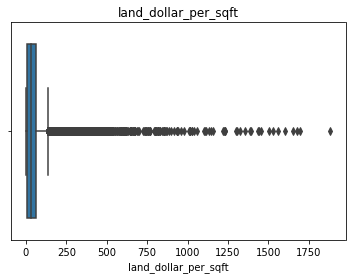

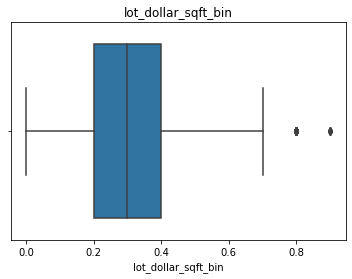

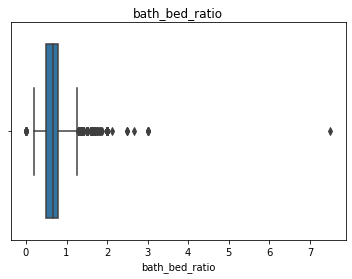

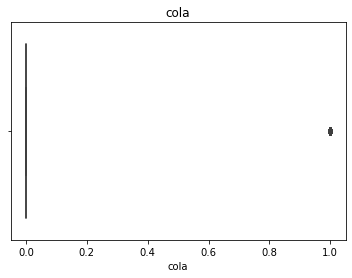

In [18]:
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()


In [19]:
def remove_outliers():
    '''
    remove outliers in bed, bath, zip, square feet, acres & tax rate
    '''

    return df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) & 
               (df.regionidzip < 100000) & 
               (df.bathroomcnt > 0) & 
               (df.bedroomcnt > 0) & 
               (df.acres < 20) &
               (df.calculatedfinishedsquarefeet < 10000) & 
               (df.taxrate < 10)
              )]


In [20]:
df = remove_outliers()

# Now that the most extreme outliers have been removed, let's look at the summary statistics of each numeric field. 
df.describe().T


,count,mean,std,min,25%,50%,75%,max
parcelid,50677.0,1.296909e+07,2.292824e+06,1.071186e+07,1.153139e+07,1.259430e+07,1.413329e+07,1.629608e+08
logerror,50677.0,1.796359e-02,1.738460e-01,-4.655420e+00,-2.476254e-02,6.844754e-03,4.038610e-02,3.394544e+00
bathroomcnt,50677.0,2.279042e+00,9.699697e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,7.000000e+00
bedroomcnt,50677.0,3.296683e+00,9.114688e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,7.000000e+00
calculatedfinishedsquarefeet,50677.0,1.895669e+03,9.291601e+02,1.520000e+02,1.265000e+03,1.649000e+03,2.279000e+03,9.848000e+03
fips,50677.0,6.049254e+03,2.115866e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,50677.0,3.402033e+07,2.720810e+05,3.334085e+07,3.382684e+07,3.401962e+07,3.418502e+07,3.481877e+07
longitude,50677.0,-1.181937e+08,3.560882e+05,-1.194753e+08,-1.183968e+08,-1.181516e+08,-1.179290e+08,-1.175723e+08
lotsizesquarefeet,50677.0,9.754763e+03,2.016309e+04,2.360000e+02,5.568000e+03,6.810000e+03,8.714000e+03,8.623290e+05
regionidcity,50677.0,3.354932e+04,4.928741e+04,3.491000e+03,1.244700e+04,2.481200e+04,4.022700e+04,3.965560e+05


In [21]:
df_la = df[df.LA == 1].drop(columns = ['parcelid', 'bedroomcnt', 'taxamount', 'taxvaluedollarcnt', 'fips', 
                                       'structure_dollar_per_sqft', 'land_dollar_per_sqft', 'yearbuilt', 
                                       'lotsizesquarefeet', 'regionidcity', 'regionidzip', 
                                       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt', 
                                       'LA', 'Ventura', 'Orange']) 


In [22]:
print(df_la.shape)


(32667, 15)


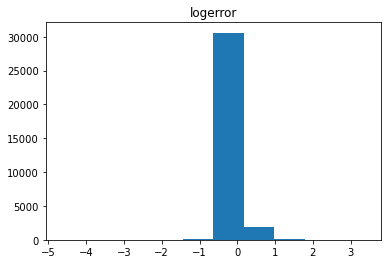

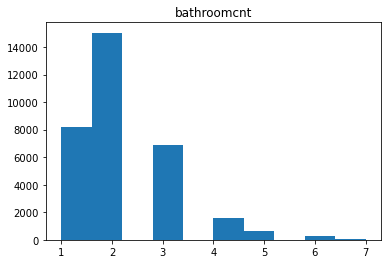

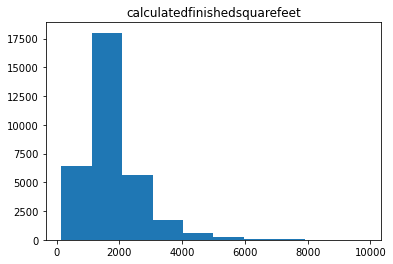

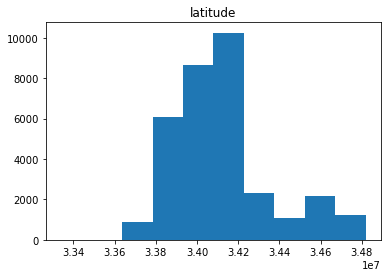

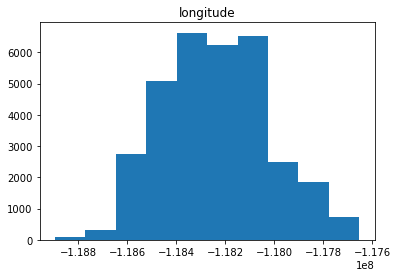

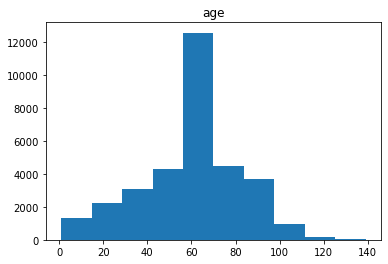

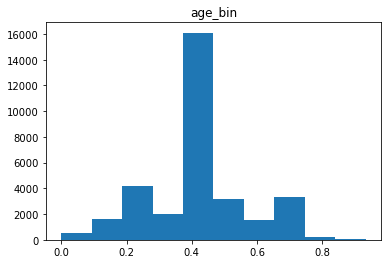

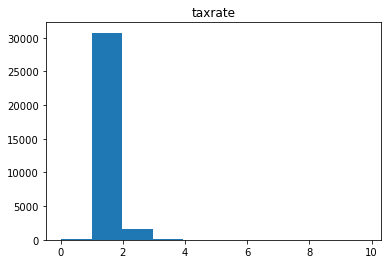

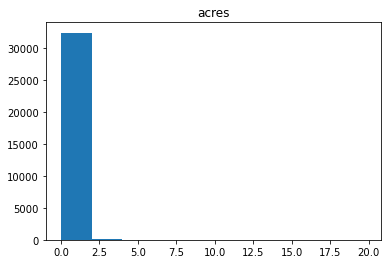

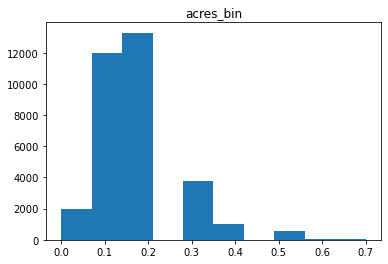

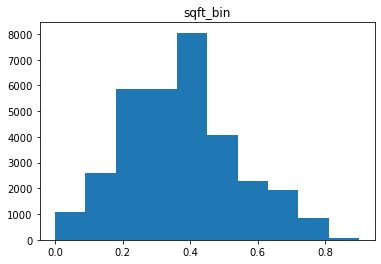

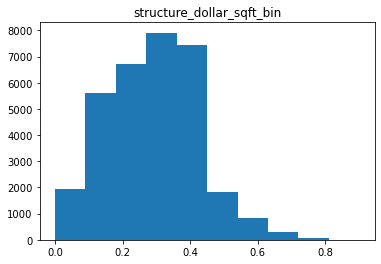

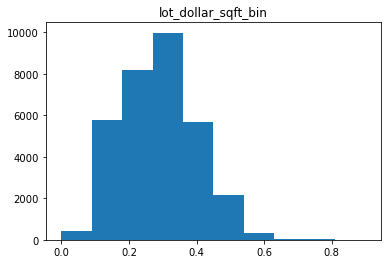

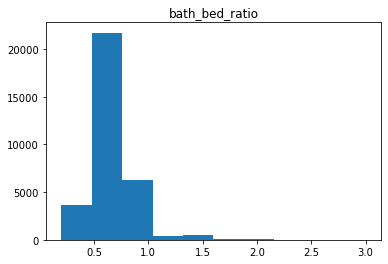

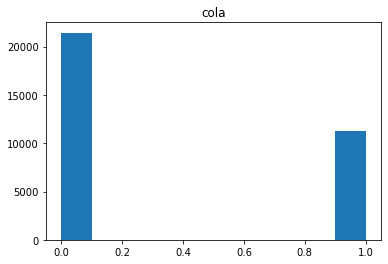

In [23]:
for col in df_la.columns:
    plt.hist(df_la[col])
    plt.title(col)
    plt.show()


In [24]:
def split(df, target_var):
    '''
    This function takes in the dataframe and target variable name as arguments and then
    splits the dataframe into train (56%), validate (24%), & test (20%)
    It will return a list containing the following dataframes: train (for exploration), 
    X_train, X_validate, X_test, y_train, y_validate, y_test
    '''
    # split df into train_validate (80%) and test (20%)
    train_validate, test = train_test_split(df, test_size=.20, random_state=13)
    # split train_validate into train(70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=13)

    # create X_train by dropping the target variable 
    X_train = train.drop(columns=[target_var])
    # create y_train by keeping only the target variable.
    y_train = train[[target_var]]

    # create X_validate by dropping the target variable 
    X_validate = validate.drop(columns=[target_var])
    # create y_validate by keeping only the target variable.
    y_validate = validate[[target_var]]

    # create X_test by dropping the target variable 
    X_test = test.drop(columns=[target_var])
    # create y_test by keeping only the target variable.
    y_test = test[[target_var]]

    partitions = [train, X_train, X_validate, X_test, y_train, y_validate, y_test]
    return partitions


In [25]:
partitions = split(df_la, target_var='logerror')


In [26]:
train = partitions[0]
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])
partitions[0] = train


In [27]:
train.logerror_bins.value_counts()


(-0.05, 0.05]    11187
(0.05, 0.2]       3081
(-0.2, -0.05]     2626
(0.2, 4.0]         894
(-5.0, -0.2]       505
Name: logerror_bins, dtype: int64

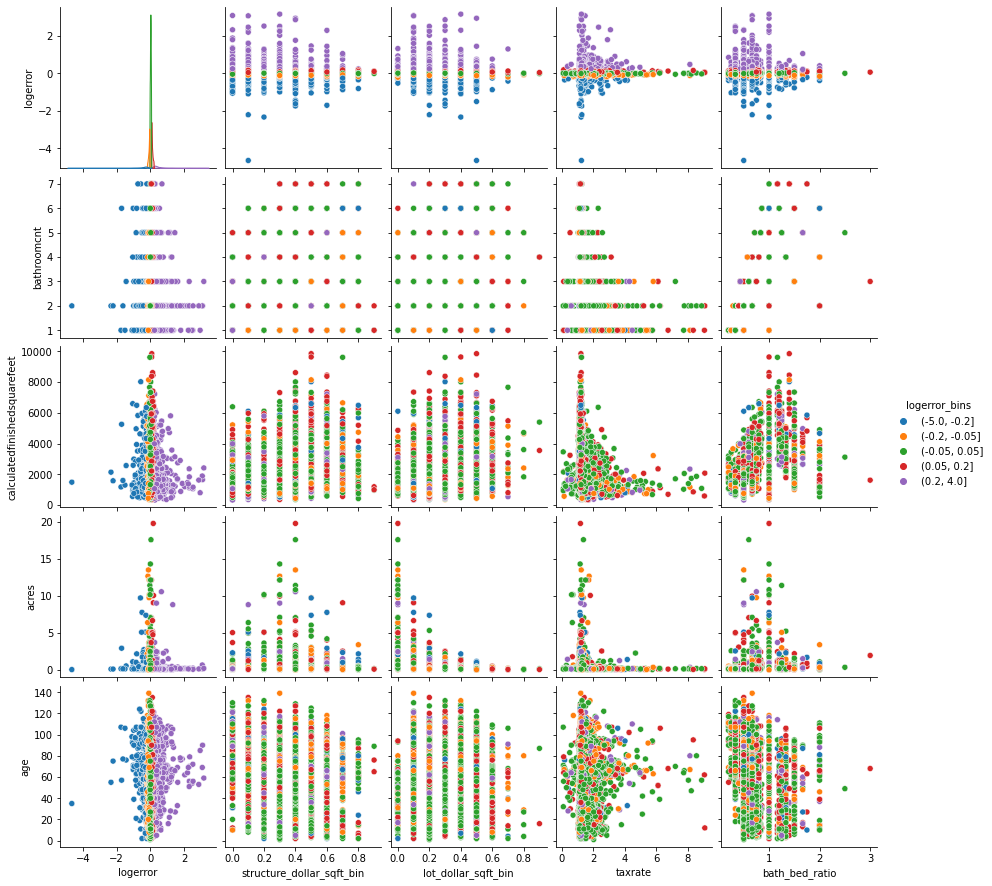

In [28]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio'],
             y_vars = ['logerror', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'acres', 'age'])


In [29]:
# the variables that still need scaling
scaled_vars = ['latitude', 'longitude', 'bathroomcnt', 'taxrate']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])


def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)

for i in range(len(X)):
    X[i] = scale_and_concat(X[i])


In [30]:
# recall: X[0] is X_train, X[1] is X_validate and X[2] is X_test
X[0].describe()


,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,age,age_bin,taxrate,acres,acres_bin,sqft_bin,structure_dollar_sqft_bin,lot_dollar_sqft_bin,bath_bed_ratio,cola,scaled_latitude,scaled_longitude,scaled_bathroomcnt,scaled_taxrate
count,18293.000000,18293.000000,1.829300e+04,1.829300e+04,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000,18293.000000
mean,2.157656,1778.312469,3.411769e+07,-1.182377e+08,60.488985,0.432158,1.393239,0.240972,0.174919,0.364298,0.274624,0.270404,0.678904,0.345269,0.529866,0.528803,0.192943,0.145798
std,0.992574,884.836252,2.312723e+05,2.155461e+05,22.442030,0.151501,0.397296,0.536560,0.100282,0.186127,0.150027,0.124927,0.240164,0.475469,0.157746,0.173980,0.165429,0.044082
min,1.000000,326.000000,3.334085e+07,-1.188928e+08,1.000000,0.000000,0.079206,0.020868,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1190.000000,3.395640e+07,-1.183979e+08,50.000000,0.333000,1.213394,0.130808,0.100000,0.200000,0.200000,0.200000,0.500000,0.000000,0.419850,0.399509,0.000000,0.125843
50%,2.000000,1542.000000,3.409118e+07,-1.182402e+08,63.000000,0.466000,1.263226,0.157966,0.200000,0.400000,0.300000,0.300000,0.666667,0.000000,0.511788,0.526780,0.166667,0.131372
75%,3.000000,2114.000000,3.420286e+07,-1.180971e+08,71.000000,0.533000,1.429257,0.203719,0.200000,0.500000,0.400000,0.400000,0.750000,1.000000,0.587960,0.642304,0.333333,0.149794
max,7.000000,9848.000000,3.480696e+07,-1.176539e+08,139.000000,0.933000,9.091901,19.796350,0.700000,0.900000,0.900000,0.900000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
# list of variables I will cluster on. 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'age_bin']
cluster_name = 'area_cluster'
k_range = range(2,20)



In [32]:
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df


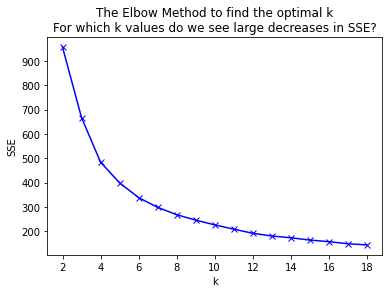

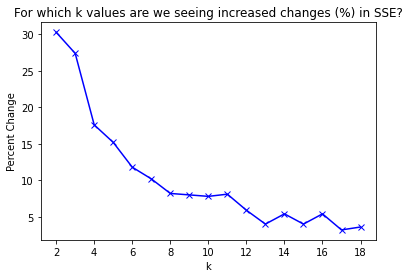

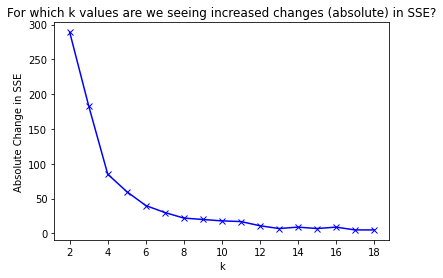

,k,sse,delta,pct_delta
0,2,955.639437,289.0,30.3
1,3,666.206471,183.0,27.4
2,4,483.654623,85.0,17.6
3,5,398.676695,60.0,15.2
4,6,338.259441,40.0,11.8
5,7,298.372594,30.0,10.2
6,8,267.957400,22.0,8.2
7,9,245.991799,20.0,8.0
8,10,226.334651,18.0,7.8
9,11,208.737267,17.0,8.1


In [33]:
find_k(X[0], cluster_vars, k_range)


In [34]:
k = 5
# as reminders: 
cluster_vars = ['scaled_latitude', 'scaled_longitude', 'age_bin']
cluster_name = 'area_cluster'


In [35]:
def create_clusters(X_train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 13)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans


In [36]:
kmeans = create_clusters(X[0], k, cluster_vars)


In [37]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df


In [38]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)


In [39]:
# label cluster for each observation in X_train (X[0] in our X list of dataframes), 
# X_validate (X[1]), & X_test (X[2])

def assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df):
    for i in range(len(X)):
        clusters = pd.DataFrame(kmeans.predict(X[i][cluster_vars]), 
                            columns=[cluster_name], index=X[i].index)

        clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

        X[i] = pd.concat([X[i], clusters_centroids], axis=1)
    return X


In [40]:
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)


In [41]:
pd.DataFrame(X[0].groupby(['area_cluster', 'centroid_scaled_latitude', 'centroid_scaled_longitude', 
                           'centroid_age_bin'])['area_cluster'].count())


,,,,area_cluster
area_cluster,centroid_scaled_latitude,centroid_scaled_longitude,centroid_age_bin,
0,0.374394,0.539382,0.441321,4501
1,0.493545,0.499519,0.622766,3833
2,0.592451,0.326064,0.376646,4645
3,0.872779,0.617564,0.236948,2018
4,0.486534,0.780624,0.395415,3296


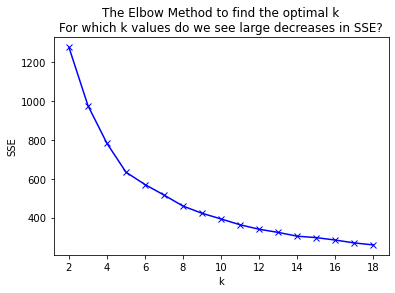

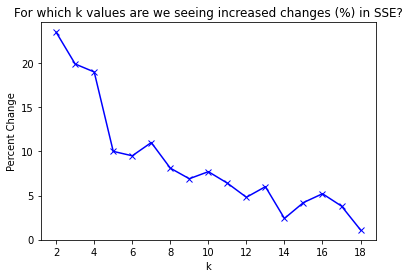

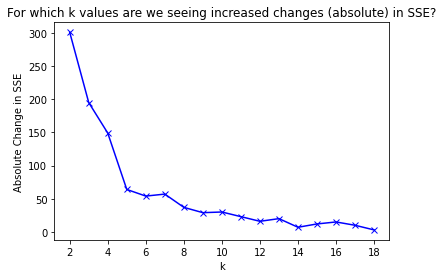

,k,sse,delta,pct_delta
0,2,1278.311082,301.0,23.5
1,3,977.411778,195.0,19.9
2,4,782.541071,149.0,19.0
3,5,633.878798,64.0,10.0
4,6,570.260603,54.0,9.5
5,7,515.853699,57.0,11.0
6,8,459.061469,37.0,8.1
7,9,421.904820,29.0,6.9
8,10,392.672047,30.0,7.7
9,11,362.621930,23.0,6.4


In [42]:
cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']
cluster_name = 'size_cluster'
k_range = range(2,20)

find_k(X[0], cluster_vars, k_range)


In [43]:
k=7
cluster_name = 'size_cluster'
cluster_vars = ['scaled_bathroomcnt', 'sqft_bin', 'acres_bin', 'bath_bed_ratio']

# fit kmeans 
kmeans = create_clusters(X[0], k, cluster_vars)

# get centroid values per variable per cluster
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)

# get cluster assignments and append those with centroids for each X partition (train, validate, test)
X = assign_clusters(kmeans, cluster_vars, cluster_name, centroid_df)


In [44]:
X_train = X[0].iloc[:,0:27]


In [45]:
pd.DataFrame(X_train.groupby(['size_cluster', 'centroid_scaled_bathroomcnt', 'centroid_sqft_bin',
                              'centroid_acres_bin', 'centroid_bath_bed_ratio'])['area_cluster'].count())


,,,,,area_cluster
size_cluster,centroid_scaled_bathroomcnt,centroid_sqft_bin,centroid_acres_bin,centroid_bath_bed_ratio,
0,0.198999,0.297110,0.152863,1.002223,1799
1,0.144061,0.405287,0.180598,0.474458,2175
2,0.006884,0.161793,0.121356,0.431288,4261
3,0.168773,0.316814,0.163503,0.667142,4984
4,0.448133,0.631062,0.254792,0.968083,1732
5,0.592759,0.653142,0.258707,1.384859,557
6,0.316457,0.546822,0.220682,0.708589,2785


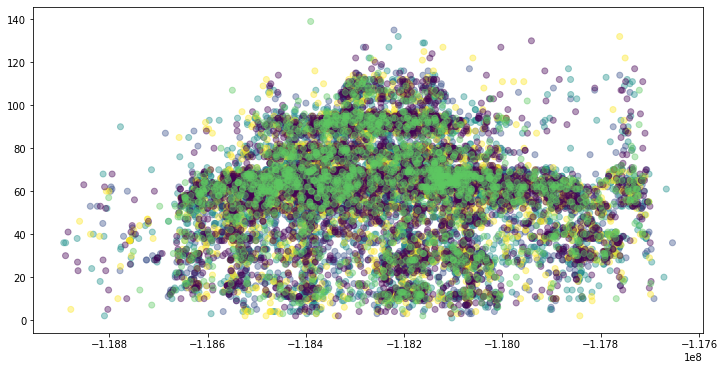

In [46]:
plt.figure(figsize=(12,6))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.scatter(y=X_train.age, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)


Text(0.5, 1.0, 'Do clusters reveal differences in age and error?')

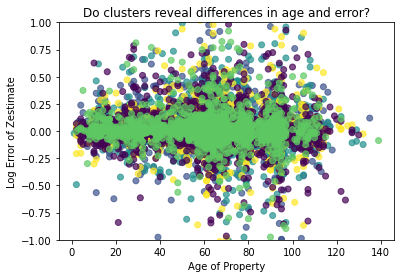

In [47]:
y_train = partitions[-3]

plt.scatter(y=y_train.logerror, x=X_train.age, c=X_train.area_cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Age of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in age and error?")


(-1.0, 1.0)

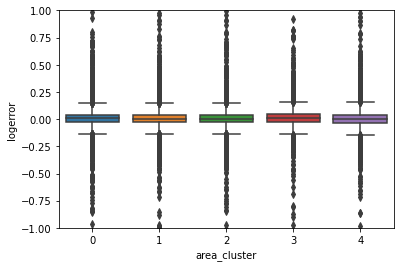

In [48]:
import seaborn as sns
sns.boxplot(y=y_train.logerror, x=X_train.area_cluster)
plt.ylim(-1, 1)
# sns.swarmplot(X_train.age_bin, y_train.logerror, hue=X_train.area_cluster)


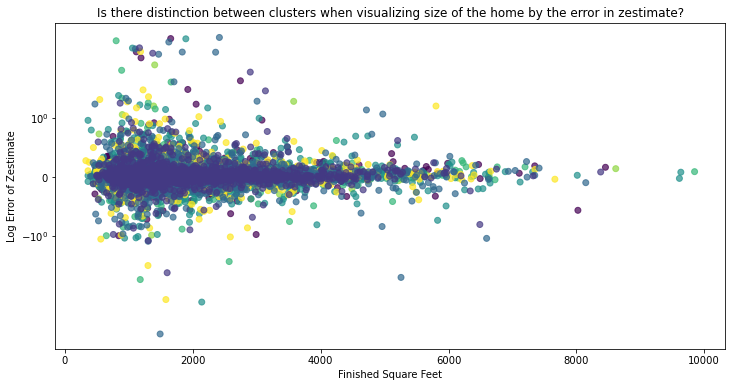

In [49]:
plt.figure(figsize=(12,6))
# plt.scatter(y=X_train.latitude, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)
plt.scatter(y=y_train.logerror, x=X_train.calculatedfinishedsquarefeet, c=X_train.size_cluster, alpha=.7)
plt.yscale('symlog')
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error of Zestimate')
plt.title('Is there distinction between clusters when visualizing size of the home by the error in zestimate?')

plt.show()


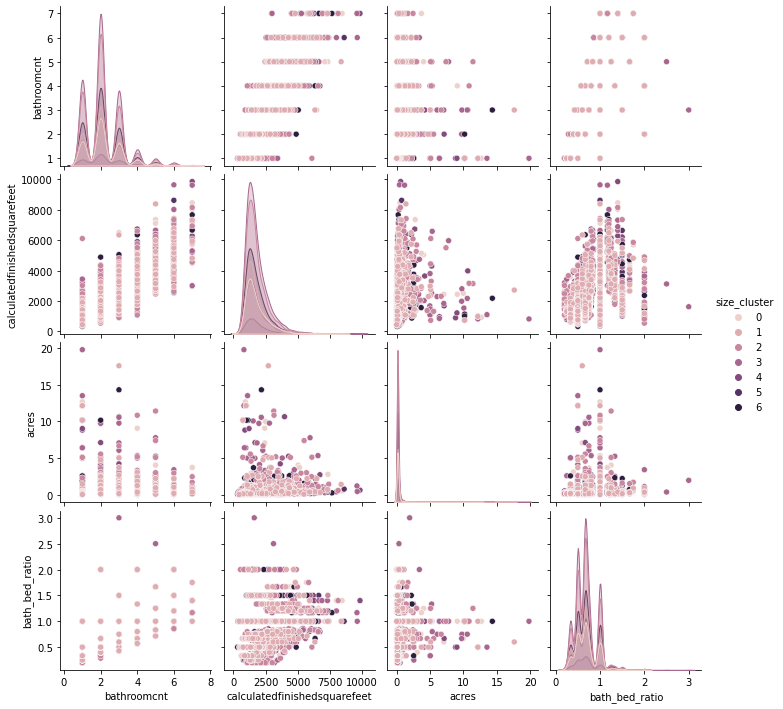

In [50]:
plt_df = X_train[['bathroomcnt', 'calculatedfinishedsquarefeet', 
                    'acres', 'bath_bed_ratio', 'size_cluster']]

sns.pairplot(data=plt_df, hue='size_cluster')


<AxesSubplot:xlabel='bath_bed_ratio', ylabel='calculatedfinishedsquarefeet'>

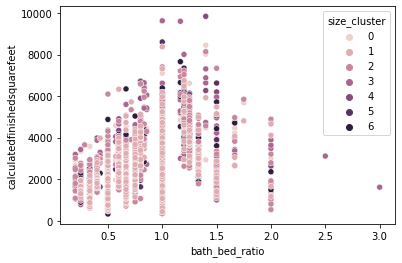

In [52]:
sns.scatterplot(x='bath_bed_ratio', y='calculatedfinishedsquarefeet', 
                data=X_train, hue='size_cluster')


In [53]:
# update datatypes of binned values to be float
X_train = X_train.astype({'size_cluster': 'category', 'area_cluster': 'category'})


In [54]:
dummy_df = pd.get_dummies(X_train[['size_cluster','area_cluster']], dummy_na=False, drop_first=[True, True])

# append dummy df cols to the original df. 
X_train = pd.concat([X_train, dummy_df], axis=1)


In [55]:
X_train.head()


,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,age,age_bin,taxrate,acres,acres_bin,sqft_bin,...,size_cluster_1,size_cluster_2,size_cluster_3,size_cluster_4,size_cluster_5,size_cluster_6,area_cluster_1,area_cluster_2,area_cluster_3,area_cluster_4
38748,3.0,1264.0,33976419.0,-118301352.0,94.0,0.666,1.217797,0.107415,0.1,0.3,...,0,0,0,0,0,0,1,0,0,0
19330,2.0,1300.0,34120981.0,-118346117.0,58.0,0.400,1.208293,0.281566,0.3,0.3,...,0,0,0,0,0,0,1,0,0,0
46192,5.0,2872.0,34141910.0,-118433056.0,90.0,0.600,1.242053,0.200964,0.2,0.6,...,0,0,0,0,0,0,1,0,0,0
22550,2.0,1344.0,34105184.0,-118377389.0,65.0,0.466,1.201040,0.080372,0.0,0.3,...,0,0,0,0,0,0,1,0,0,0
45428,4.0,3730.0,34125421.0,-118030828.0,28.0,0.200,1.146520,0.194812,0.2,0.7,...,0,0,0,0,0,0,1,0,0,0


In [56]:
import matplotlib
import sklearn

print('Versions')
print('Pandas:', pd.__version__)
print('Numpy:', np.__version__)
print('Matplotlib:', matplotlib.__version__)
print('Seaborn:', sns.__version__)
print('Scikit-Learn:', sklearn.__version__)



Versions
Pandas: 1.4.2
Numpy: 1.21.5
Matplotlib: 3.5.1
Seaborn: 0.11.2
Scikit-Learn: 1.0.2


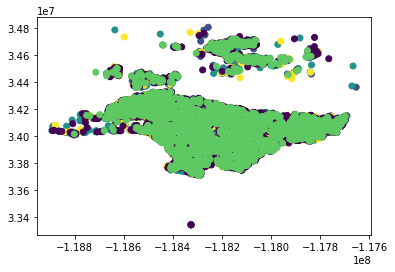

In [59]:
plt.scatter(X_train.longitude, X_train.latitude, c = X_train.area_cluster)


In [61]:
# X_train.groupby(['area_cluster_id', 'size_cluster_id'])['structure_dollar_per_sqft'].describe()


In [66]:
 df.to_csv('after_code.csv')